In [1]:
import numpy as np
from control import matlab
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# プラント制御の例題
- control.matlab.lqrに最適レギュレータが実装されている
    - 関数から帰ってくるF,X,Eは
        - F:フィードバックゲイン
        - X:リカッチ方程式の解
        - E:閉ループ系の極

In [2]:
output_names = ["発電機端子電圧", "発電機内部相差角"]
input_names = ["励磁機制御系の設定電圧", "タービンへの蒸気流量"]
A = np.array(pd.read_csv("./data/sim1/sys_A.csv", header=None))
B = np.array(pd.read_csv("./data/sim1/sys_b.csv", header=None))
C = np.array(pd.read_csv("./data/sim1/sys_c.csv", header=None))

Pss = matlab.ss(A, B, C, 0)

## 最適レギュレータの設計

In [3]:
# 設計パラメータ
Q = np.diag([10]*9)
R = np.diag([10]*2)

In [4]:
F, X, E = matlab.lqr(Pss.A, Pss.B, Q, R) #ここでリカッチ方程式を解いてる

In [5]:
#固有値の確認
print("元々の固有値")
display(np.linalg.eigvals(A))
print("状態フィードバック系の固有値")
# display(np.linalg.eigvals(A-np.dot(B,F)))
display(E)

元々の固有値


array([-1.06803978e+02+15.80269197j, -1.06803978e+02-15.80269197j,
       -6.22446902e-02+10.4594185j , -6.22446902e-02-10.4594185j ,
       -1.29873340e+01 +0.j        , -3.40349396e+01 +9.95086901j,
       -3.40349396e+01 -9.95086901j, -2.96303407e+01 +0.j        ,
       -5.00000000e+00 +0.j        ])

状態フィードバック系の固有値


array([-107.930374 +15.291009j, -107.930374 -15.291009j,
        -34.78741   +9.299614j,  -34.78741   -9.299614j,
        -29.380627  +0.j      ,   -9.922343 +13.230641j,
         -9.922343 -13.230641j,  -11.765754  +0.j      ,
         -3.1871777 +0.j      ], dtype=complex64)

## 応答の確認

### 状態フィードバックなし

In [6]:
Td = np.arange(0, 2, 0.01) #シミュレーション時間0~1s,0.01s刻み

X0 = [1]*9 # 初期状態量
sys = matlab.ss(Pss.A, Pss.B, C, 0)
y, tt = matlab.initial(sys, Td, X0) #線形システムシミュレータ

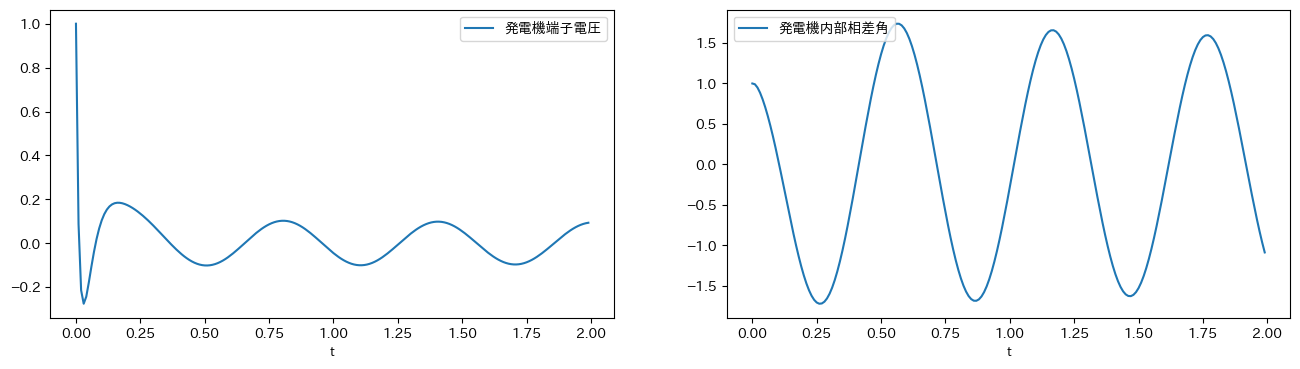

In [7]:
df = pd.concat((pd.DataFrame(tt),pd.DataFrame(y)), axis = 1)
df.columns = ["t", output_names[0], output_names[1]]

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

df.plot(ax = ax1, x = "t", y = output_names[0])
df.plot(ax = ax2, x = "t", y = output_names[1])

plt.show()

### 最適レギュレータで状態フィードバック系を構成

In [8]:
Td = np.arange(0, 5, 0.01) #シミュレーション時間0~1s,0.01s刻み
Ud = 0*(Td>0) #入力信号（ステップ入力）

X0 = [1]*9 # 初期状態量
sys = matlab.ss(Pss.A-np.dot(Pss.B,F), Pss.B, C, 0)
y, tt, x = matlab.lsim(sys, np.vstack((Ud,Ud)).T, Td, X0) #線形システムシミュレータ

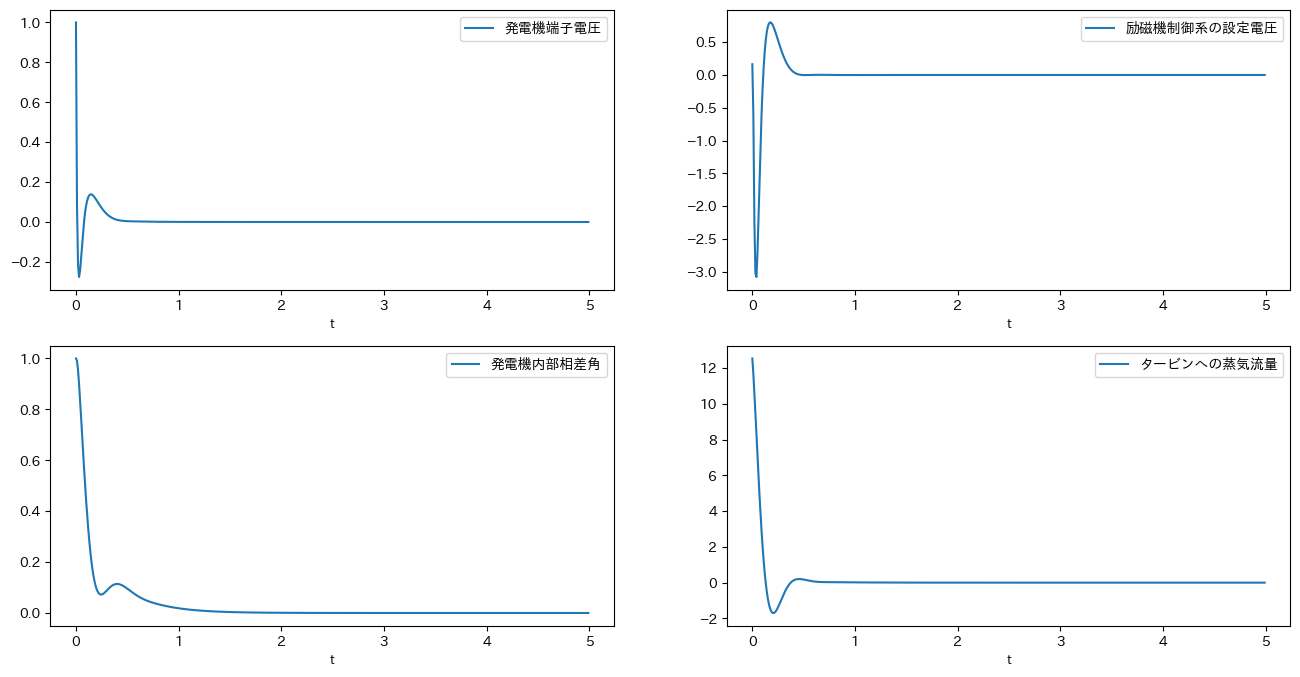

In [9]:
df = pd.concat((pd.DataFrame(tt), pd.DataFrame(y) ,pd.DataFrame(np.dot(x, -F.T))), axis = 1) #u =-Fx 
df.columns = ["t", output_names[0], output_names[1], input_names[0], input_names[1]]

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(2, 2, 4)

df.plot(ax = ax1, x = "t", y = output_names[0])
df.plot(ax = ax2, x = "t", y = output_names[1])
df.plot(ax = ax3, x = "t", y = input_names[0])
df.plot(ax = ax4, x = "t", y = input_names[1])

plt.show()

In [36]:
sigma1 = 0.5 * np.random.randn(*A.shape)
sigma2 = 0.5 * np.random.randn(*B.shape)

In [39]:
F, X, E = matlab.lqr(Pss.A + sigma1, Pss.B + sigma2, Q, R)

In [40]:
Td = np.arange(0, 5, 0.01) #シミュレーション時間0~1s,0.01s刻み
Ud = 0*(Td>0) #入力信号（ステップ入力）

X0 = [1]*9 # 初期状態量
sys = matlab.ss(Pss.A-np.dot(Pss.B,F), Pss.B, C, 0)
y, tt, x = matlab.lsim(sys, np.vstack((Ud,Ud)).T, Td, X0) #線形システムシミュレータ

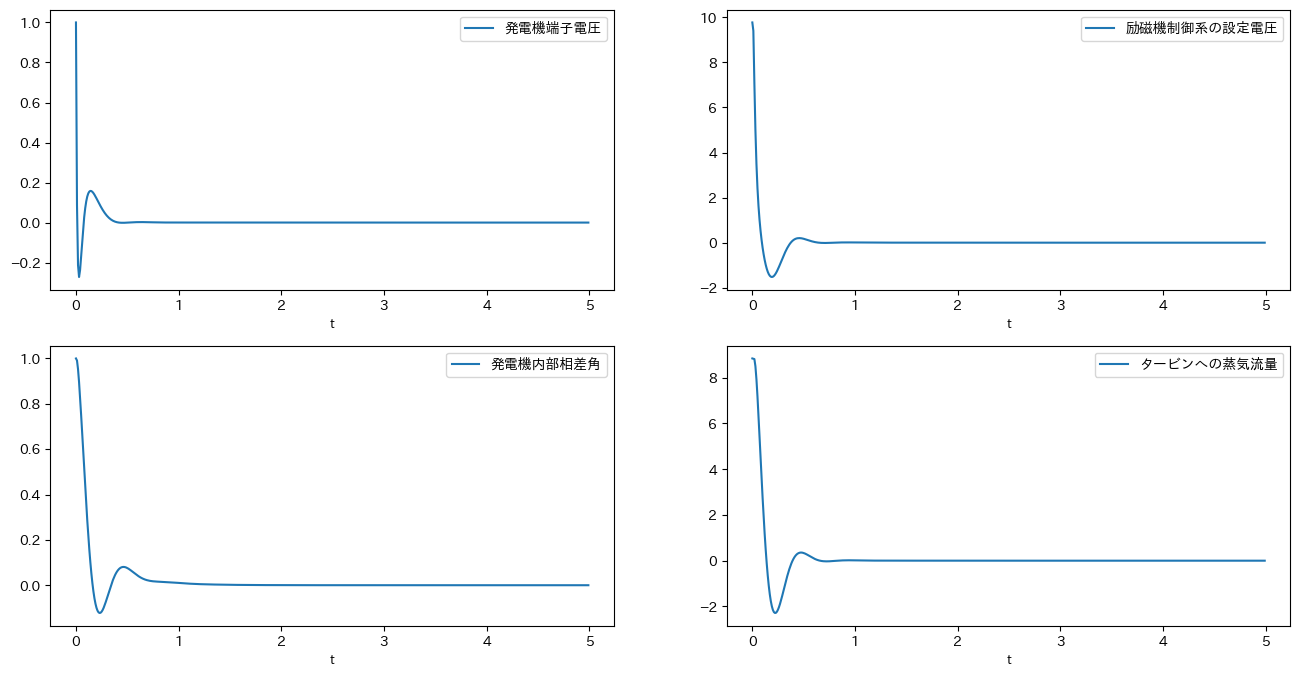

In [41]:
df = pd.concat((pd.DataFrame(tt), pd.DataFrame(y) ,pd.DataFrame(np.dot(x, -F.T))), axis = 1) #u =-Fx 
df.columns = ["t", output_names[0], output_names[1], input_names[0], input_names[1]]

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(2, 2, 4)

df.plot(ax = ax1, x = "t", y = output_names[0])
df.plot(ax = ax2, x = "t", y = output_names[1])
df.plot(ax = ax3, x = "t", y = input_names[0])
df.plot(ax = ax4, x = "t", y = input_names[1])

plt.show()